In [1]:
#pip install lightgbm
#conda install -c conda-forge lightgbm


In [1]:
import joblib
import pandas as pd
import threading
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor

In [2]:
print(lgb.__version__)


4.5.0


In [3]:
data = pd.read_csv("DatasetInitalComplete.csv", low_memory=False)
data = data.drop(["7","10","11","13","14"],axis = 1)

In [4]:
data.shape

(400000, 53)

In [5]:
data

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,1,2,3,4,5,6,8,9,12,15
0,1,80.0,0.0,0.0,9.27,18.093367,13.054772,19.090458,21.211776,26.302386,...,0.992879,1.614020,0.472059,5.650503,0.037528,0.952930,0.240838,37.515355,5.879538,0.141073
1,1,75.0,1.0,3.0,3.88,26.187010,21.394010,25.553420,24.914770,36.588750,...,0.998616,1.438920,0.526167,4.973141,0.088282,0.991787,0.315452,29.518401,4.764154,0.181296
2,1,80.0,1.0,0.0,6.55,33.480140,24.249430,26.160100,25.295430,42.488470,...,0.976854,2.008492,0.403345,8.597085,0.034536,0.849163,0.192565,56.186421,7.140923,0.150849
3,1,60.0,1.0,4.0,5.27,25.872050,20.194650,26.805590,28.459890,37.254570,...,0.973226,1.863920,0.404943,6.184975,0.042374,0.832057,0.194337,38.999721,6.448128,0.180971
4,1,55.0,1.0,1.0,5.29,30.966662,22.008635,24.066940,26.734379,39.219278,...,0.980691,1.882010,0.409715,6.650251,0.038820,0.877775,0.197552,42.312589,6.516821,0.165631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,0,60.0,0.0,1.0,3.10,20.396390,8.700477,19.498260,22.526430,28.216930,...,0.993499,0.700879,0.693530,1.181281,0.080221,0.964553,0.436643,6.484213,2.356538,0.211512
399996,0,65.0,1.0,4.0,2.66,18.325057,14.385684,27.391522,25.084622,32.956080,...,0.974921,1.771508,0.421346,5.659397,0.039210,0.857096,0.208423,32.171421,5.665769,0.164087
399997,0,65.0,0.0,4.0,4.66,21.155608,17.250798,27.887630,23.743460,35.003995,...,0.969403,1.930678,0.393691,6.472789,0.040591,0.806044,0.183824,41.111117,6.841718,0.177144
399998,0,50.0,1.0,4.0,2.62,20.209510,16.428130,34.063210,31.104090,39.607160,...,0.971324,1.683367,0.430196,4.941759,0.044474,0.823461,0.211837,30.236066,5.675103,0.182123


In [6]:
data.columns

Index(['target', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B',
       'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
       'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'mel_mitotic_index', 'mel_thick_mm',
       'tbp_lv_dnn_lesion_confidence', '0', '1', '2', '3', '4', '5', '6', '8',
       '9', '12', '15'],
      dtype='object')

In [7]:
non_numerical_columns = data.select_dtypes(exclude=['number']).columns

# Convert to a list if needed
non_numerical_columns_list = list(non_numerical_columns)

print(non_numerical_columns_list)

[]


In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [10]:
import pickle

data_new = data
data1 = {}
save_file = open("cases.dat", "wb")

for j in non_numerical_columns_list:
    a = list(set(list(data_new[j])))
    index = 0
    dic = {}
    for i in a:
        dic[i] = index
        index += 1

    data1[j] = dic

pickle.dump(data1, save_file)
save_file.close()

In [11]:
data_file = open("cases.dat", "rb")
cases = pickle.load(data_file)
type(cases)
data_file.close()

In [12]:
for i in cases:
    for j in cases[i]:
        data_new[i] = data_new[i].replace(j, cases[i][j])
        

In [13]:
classes = []
for column in non_numerical_columns_list:
    data[column] = le.fit_transform(data[column])
    print(le.classes_)
    classes.append(le.classes_)

In [14]:
import pickle
data_file = open("cases.dat", "rb")
cases = pickle.load(data_file)
type(cases)
data_file.close()

In [15]:
for i in cases:
    for j in cases[i]:
        data_new[i] = data_new[i].replace(j, cases[i][j])

In [16]:
data_new

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,1,2,3,4,5,6,8,9,12,15
0,1,80.0,0.0,0.0,9.27,18.093367,13.054772,19.090458,21.211776,26.302386,...,0.992879,1.614020,0.472059,5.650503,0.037528,0.952930,0.240838,37.515355,5.879538,0.141073
1,1,75.0,1.0,3.0,3.88,26.187010,21.394010,25.553420,24.914770,36.588750,...,0.998616,1.438920,0.526167,4.973141,0.088282,0.991787,0.315452,29.518401,4.764154,0.181296
2,1,80.0,1.0,0.0,6.55,33.480140,24.249430,26.160100,25.295430,42.488470,...,0.976854,2.008492,0.403345,8.597085,0.034536,0.849163,0.192565,56.186421,7.140923,0.150849
3,1,60.0,1.0,4.0,5.27,25.872050,20.194650,26.805590,28.459890,37.254570,...,0.973226,1.863920,0.404943,6.184975,0.042374,0.832057,0.194337,38.999721,6.448128,0.180971
4,1,55.0,1.0,1.0,5.29,30.966662,22.008635,24.066940,26.734379,39.219278,...,0.980691,1.882010,0.409715,6.650251,0.038820,0.877775,0.197552,42.312589,6.516821,0.165631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,0,60.0,0.0,1.0,3.10,20.396390,8.700477,19.498260,22.526430,28.216930,...,0.993499,0.700879,0.693530,1.181281,0.080221,0.964553,0.436643,6.484213,2.356538,0.211512
399996,0,65.0,1.0,4.0,2.66,18.325057,14.385684,27.391522,25.084622,32.956080,...,0.974921,1.771508,0.421346,5.659397,0.039210,0.857096,0.208423,32.171421,5.665769,0.164087
399997,0,65.0,0.0,4.0,4.66,21.155608,17.250798,27.887630,23.743460,35.003995,...,0.969403,1.930678,0.393691,6.472789,0.040591,0.806044,0.183824,41.111117,6.841718,0.177144
399998,0,50.0,1.0,4.0,2.62,20.209510,16.428130,34.063210,31.104090,39.607160,...,0.971324,1.683367,0.430196,4.941759,0.044474,0.823461,0.211837,30.236066,5.675103,0.182123


In [219]:
df_target_1 = data[data['target'] == 1]
df_target_0 = data[data['target'] == 0]

# Select the last 40 positive and negative samples for the test set
test_positive = df_target_1.tail(40)
test_negative = df_target_0.tail(40)

# Remove the last 40 samples from df_target_1 and df_target_0 (creating new DataFrames)
df_target_1 = df_target_1.iloc[:-40]  # All rows except the last 40 positives
df_target_0 = df_target_0.iloc[:-40]  # All rows except the last 40 negatives

# Concatenate the last 40 positives and negatives into the test set
test_set = pd.concat([test_positive, test_negative], ignore_index=True)

# Remaining samples in df_target_1 and df_target_0 are now updated
test_set

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,1,2,3,4,5,6,8,9,12,15
0,1,55.0,1.0,0.0,9.53,23.854059,15.407355,20.493286,22.711772,31.448226,...,0.982981,1.928518,0.412657,7.512085,0.036913,0.893531,0.199944,47.151497,6.746231,0.156583
1,1,80.0,1.0,2.0,16.40,16.371787,15.457629,16.975724,20.511455,23.584118,...,0.995487,1.553769,0.464449,4.505377,0.036223,0.972531,0.229453,27.574264,5.476051,0.142125
2,1,55.0,0.0,0.0,7.48,25.711526,17.473305,25.697414,25.440119,36.351611,...,0.987482,1.703090,0.438763,5.360729,0.039874,0.924270,0.220147,32.541218,5.735000,0.160379
3,1,65.0,1.0,3.0,1.07,28.581466,25.153961,33.832074,31.270528,44.288931,...,0.974787,1.699724,0.426182,5.014497,0.041026,0.835442,0.200962,32.700228,6.173051,0.174352
4,1,65.0,0.0,4.0,1.10,26.453680,23.072678,19.165143,20.453265,32.666495,...,0.936247,2.815704,0.318144,15.612487,0.032847,0.610805,0.147875,95.447970,9.121615,0.164574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,60.0,0.0,1.0,3.10,20.396390,8.700477,19.498260,22.526430,28.216930,...,0.993499,0.700879,0.693530,1.181281,0.080221,0.964553,0.436643,6.484213,2.356538,0.211512
76,0,65.0,1.0,4.0,2.66,18.325057,14.385684,27.391522,25.084622,32.956080,...,0.974921,1.771508,0.421346,5.659397,0.039210,0.857096,0.208423,32.171421,5.665769,0.164087
77,0,65.0,0.0,4.0,4.66,21.155608,17.250798,27.887630,23.743460,35.003995,...,0.969403,1.930678,0.393691,6.472789,0.040591,0.806044,0.183824,41.111117,6.841718,0.177144
78,0,50.0,1.0,4.0,2.62,20.209510,16.428130,34.063210,31.104090,39.607160,...,0.971324,1.683367,0.430196,4.941759,0.044474,0.823461,0.211837,30.236066,5.675103,0.182123


In [220]:
#pip install matplotlib

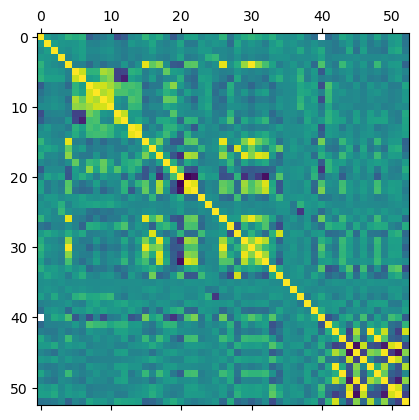

In [221]:
correlation_matrix = batch1.corr()
import matplotlib.pyplot as plt
plt.matshow(correlation_matrix, cmap='viridis')
plt.show()


In [222]:
correlated_pairs = []
threshold = 0.95
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if ((correlation_matrix.iloc[i, j]) > threshold):
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            correlated_pairs.append((colname1, colname2, correlation_matrix.iloc[i, j]))

# Print the correlated pairs
print("Pairs of columns with correlation above threshold:")
print(len(correlated_pairs))
for pair in correlated_pairs:
    print(f"Columns: {pair[0]} and {pair[1]} with correlation: {pair[2]:.2f}")

Pairs of columns with correlation above threshold:
7
Columns: tbp_lv_perimeterMM and clin_size_long_diam_mm with correlation: 0.98
Columns: tbp_lv_perimeterMM and tbp_lv_minorAxisMM with correlation: 0.95
Columns: 5 and 0 with correlation: 0.97
Columns: 6 and 1 with correlation: 0.99
Columns: 8 and 3 with correlation: 0.98
Columns: 9 and 4 with correlation: 0.99
Columns: 12 and 2 with correlation: 0.98


In [223]:
##train_set, test_set = train_test_split(batch1, test_size=0.1, stratify=batch1['target'], random_state=42)
#scaler = StandardScaler()
#X_train = train_set.drop(columns=['target'])
#y_train = train_set['target']
#X_test = test_set.drop(columns=['target'])
#y_test = test_set['target']
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [224]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [241]:
tprsacc = []
final_predict_data = data.drop(["target"],axis=1)

def trainer(number,batch):
    #print(pd.DataFrame(batch))
    #print(number)
    scaler = StandardScaler()

    trainn_set, testn_set = train_test_split(batch, test_size=0.2, stratify=batch['target'], random_state=42)
    X_trainn = trainn_set.drop(columns=['target'])
    y_trainn = trainn_set['target']
    X_testn= testn_set.drop(columns=['target'])
    y_testn = testn_set['target']
    X_trainn = scaler.fit_transform(X_trainn)
    X_testn = scaler.transform(X_testn)
    
    model = lgb.LGBMClassifier(verbose=-1,class_type = 'balanced')
    model.fit(X_trainn, y_trainn)
    print("model"+str(number))
    name = "model" + str(number) + ".joblib"
    
    predictions = model.predict(X_testn)
    tn, fp, fn, tp = confusion_matrix(y_testn, predictions).ravel()
    accuracy = accuracy_score(y_testn,predictions)
    tprsacc.append((tp/(tp+fn),accuracy))

    joblib.dump(model, name)
    
    #predictions = model.predict(X_testn)
    #tn, fp, fn, tp = confusion_matrix(y_testn, predictions).ravel()
    
    #accuracy = accuracy_score(y_testn,predictions)
    #print("model number"+str(i)+" true positives: "+str(tp/(tp+fn)))
    #print("model number"+str(i)+" accuracu: "+str(accuracy))
    
    
    # Make predictions and evaluate
    


In [242]:
threads = []
import time

start_time = time.time()


for i in range(0,1018):
    batch = batch1 = pd.concat([df_target_1, df_target_0[i*352:(i*352)+352]], ignore_index=True)
       
    thread = threading.Thread(target=trainer, args=(i,batch))
    threads.append(thread)
    thread.start()
end_time = time.time()
total_time = end_time - start_time
total_time
#batch

model0
model1
model2
model4model5

model3
model6
model8
model11
model9
model10
model13
model7
model15
model17
model18
model16
model12
model21
model25
model22
model14
model23
model26
model28
model27
model29
model30
model31
model36
model20
model33
model19
model38
model32
model34
model40
model24
model35
model39
model45
model44
model43
model48
model47
model41
model53
model49
model51
model37
model42
model58
model61
model62
model65
model68
model66
model69
model46
model75
model52
model56
model50
model55
model70
model63
model57
model79
model86
model54
model90
model87
model97
model59
model64


41.844813108444214

model74
model95
model99
model100
model109
model67
model78
model60
model73
model84
model115
model114
model131
model116
model76
model83
model123
model89
model85
model125
model77
model134
model81
model82
model113
model71
model136
model141
model92
model72
model94
model102
model111
model165
model149
model108
model105
model112
model91
model118
model93
model124
model177
model106
model180
model103
model198
model185
model190
model117
model201
model170
model129
model80
model120
model173
model122
model140
model96
model179
model235
model110
model192
model128
model184
model127
model121
model98
model153
model88
model132
model143
model148
model145
model158
model138
model150
model151
model157
model139
model147
model133
model101
model130
model249
model161
model154
model156
model135
model162
model104
model214
model187
model142
model278
model294
model119
model195
model193
model182
model144
model171
model183
model308
model167
model152
model137
model172
model212
model168
model217
model197
model159
model194

In [243]:
tprsacc 

[(0.8714285714285714, 0.8226950354609929),
 (0.8714285714285714, 0.8865248226950354),
 (0.8714285714285714, 0.8723404255319149),
 (0.8714285714285714, 0.8652482269503546),
 (0.8857142857142857, 0.8652482269503546),
 (0.8857142857142857, 0.8865248226950354),
 (0.9, 0.9148936170212766),
 (0.8857142857142857, 0.8723404255319149),
 (0.8285714285714286, 0.8439716312056738),
 (0.8571428571428571, 0.8581560283687943),
 (0.8714285714285714, 0.8581560283687943),
 (0.8857142857142857, 0.8794326241134752),
 (0.8857142857142857, 0.8652482269503546),
 (0.8857142857142857, 0.8865248226950354),
 (0.8714285714285714, 0.8794326241134752),
 (0.8857142857142857, 0.8865248226950354),
 (0.8714285714285714, 0.8368794326241135),
 (0.8714285714285714, 0.8439716312056738),
 (0.8857142857142857, 0.8723404255319149),
 (0.8714285714285714, 0.8794326241134752),
 (0.8571428571428571, 0.8865248226950354),
 (0.8714285714285714, 0.8723404255319149),
 (0.8285714285714286, 0.851063829787234),
 (0.8857142857142857, 0.851

In [244]:
sorted_based_on_tp = max(tprsacc , key=lambda x: x[0])
sorted_based_on_tp

(0.9428571428571428, 0.8794326241134752)

In [245]:
sorted_based_on_acc = max(tprsacc , key=lambda x: x[1])
sorted_based_on_acc

(0.9, 0.9361702127659575)

In [246]:
testing_predictions = {}

In [247]:
testing_predictions = {}
#testing_predictions_lock = threading.Lock()

def tester(data, model_name):
    scaler = StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(data))
    for i in range(len(data)):
        # Prepare the test data
        test_datan = data.iloc[[i]]
        
        # Load the model
        #model_name = f"model{model_number}.joblib"
        model = joblib.load(model_name)
        
        # Predict using the model
        prediction = model.predict(test_datan)
        
        # Initialize the list for key `i` if it does not exist
        if i not in testing_predictions:
            testing_predictions[i] = []
        
        # Append the prediction to the list
        testing_predictions[i].append(prediction[0])


In [248]:
#x1test = x1testset.drop(columns=['target'])
#x0test = x0testset.drop(columns=['target'])
#y1testset = x1testset['target']
#y0testset = x0testset['target']
#xInput = pd.concat([x1test,x0test],ignore_index=True).head(400)
#yOutput = pd.concat([y1testset,y0testset],ignore_index=True).head(400)
test_set_targets = test_set['target']
test_set_input = test_set.drop(columns = ['target'])
nummod = 10
#models = [tprsacc[value] for value in tprsacc]
#print(models)
#print(tprsacc)
for i  in range(0,1000):
    model_name = name = "model" + str(i) + ".joblib"
    tester(test_set_input, model_name)

In [249]:
hhh = testing_predictions

In [250]:
hhh

{0: [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  

In [251]:
print(hhh[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [252]:
for key, value in testing_predictions.items():
    # Check if the value is a list of lists, a list, or a single value
    if isinstance(value, list):
        # If it's a list of lists, flatten it
        if all(isinstance(sublist, list) for sublist in value):
            flat_predictions = [item for sublist in value for item in sublist]
        else:
            # If it's a simple list, use it directly
            flat_predictions = value
    else:
        # If it's a single value, convert it to a list
        flat_predictions = [value]
    
    # Convert to pandas Series
    prediction_series = pd.Series(flat_predictions)
    
    # Find the mode (most frequent value)
    mode_value = prediction_series.mode().iloc[0]
    
    # Replace the list with the mode value
    testing_predictions[key] = mode_value

print(testing_predictions)

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 0, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 0, 27: 0, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1, 39: 1, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 1, 49: 0, 50: 1, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 1, 69: 0, 70: 0, 71: 0, 72: 0, 73: 1, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0}


In [253]:
from itertools import chain
testing_predictions_list = list(chain.from_iterable(
    [value] if isinstance(value, (int, float, np.integer, np.floating)) else value 
    for value in testing_predictions.values()
))

print(testing_predictions_list)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [254]:
testing_predictions_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0]

In [255]:
print(testing_predictions)

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 0, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 0, 27: 0, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1, 39: 1, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 1, 49: 0, 50: 1, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 1, 69: 0, 70: 0, 71: 0, 72: 0, 73: 1, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0}


In [256]:
X_test = pd.DataFrame(xInput)

# Select the "target" column from data_new using the indices of X_test
y_test = data_new.loc[xInput.index, "target"]

In [268]:
tn, fp, fn, tp = confusion_matrix(test_set_targets, testing_predictions_list).ravel()
recall = tp/(tp+fn)
print("true positive rate:",tp/(tp+fn))
print("precision:",tp/(tp+fp))
precision = tp/(tp+fp)
accuracy = accuracy_score(test_set_targets,testing_predictions_list)
print(tp, tn , fp , fn)
print("accuracy:",accuracy)
fscore = 2/((1/recall)+(1/precision))
print("f score:",fscore)

true positive rate: 0.9
precision: 0.8780487804878049
36 35 5 4
accuracy: 0.8875
f score: 0.8888888888888888
